In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

!pip3 install tensorflow_hub
import tensorflow_hub as hub


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



In [50]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

''

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import layers


In [3]:
data_file = "../../data/data_stat.txt"
dtf = pd.read_csv(data_file, sep = "\|\|", engine = "python")

In [4]:
dtf.columns

Index(['ID', 'Gene', 'Variation', 'Class', 'Text_x', 'Text_y', 'Score'], dtype='object')

In [5]:
text_x = dtf["Text_x"]
text_y = dtf["Text_y"]
score = dtf["Score"]

In [5]:
score

0       2
1       1
2       1
3       1
4       1
       ..
3311    1
3312    2
3313    1
3314    1
3315    1
Name: Score, Length: 3316, dtype: int64

In [6]:
count_score = score.astype("str").astype("category").value_counts().tolist()

In [5]:
count_score

[2398, 380, 279, 158, 53, 46, 2]

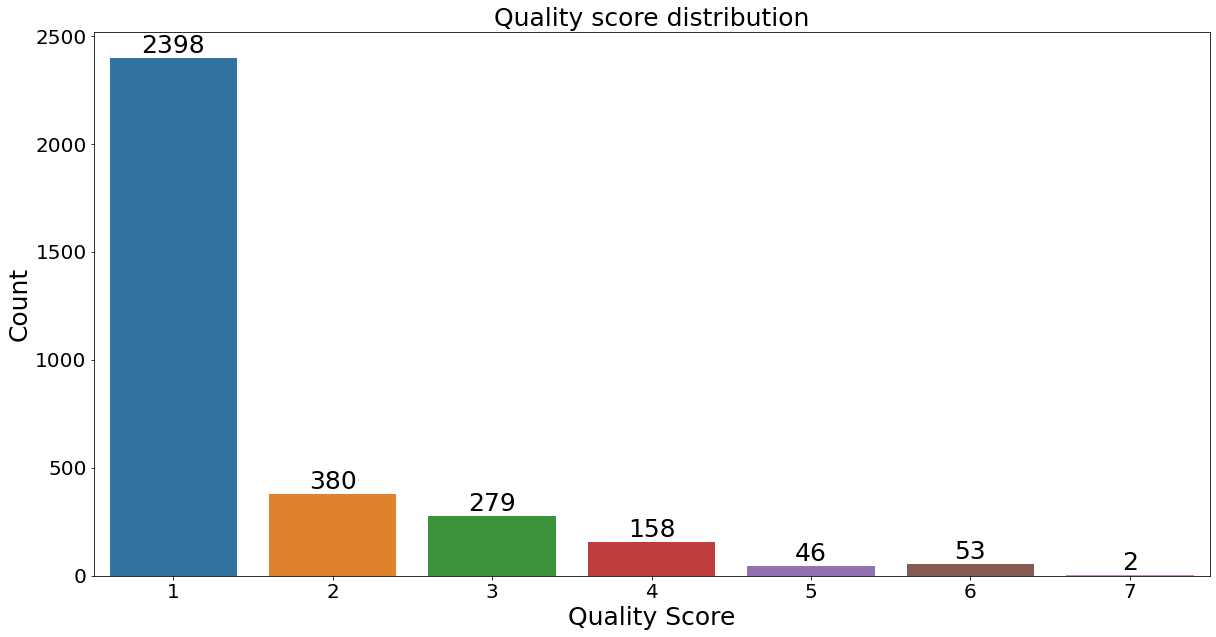

In [7]:
plt.figure(figsize=(20,10))
g = sns.countplot(x = score)
plt.title("Quality score distribution", fontsize = 25)
g.bar_label(g.containers[0], fontsize = 25)

plt.xlabel("Quality Score",fontsize = 25)
plt.ylabel("Count",fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [8]:
length_x = text_x.apply(lambda line: len(line)).mean()

In [9]:
length_y = text_y.apply(lambda line: len(line)).mean()

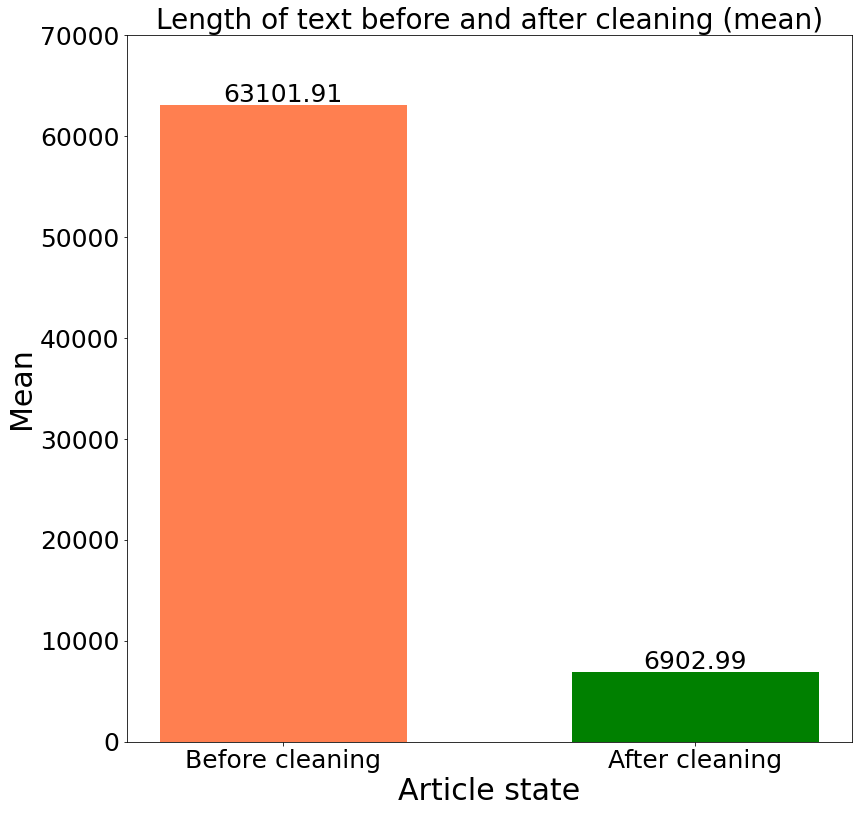

In [10]:

figure, axes = plt.subplots()
figure.set_figheight(13)
figure.set_figwidth(13)
plt.bar(["Before cleaning","After cleaning"], [length_x, length_y] , width = 0.6, color = ["coral", "green"])
plt.ylim(0,70000)

for p in axes.patches:
    axes.annotate(text=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points', fontsize = 25)

plt.xlabel("Article state",fontsize = 30)
plt.ylabel("Mean",fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.title("Length of text before and after cleaning (mean)", fontsize = 28)
plt.show()

In [10]:
len_x = text_x.apply(lambda line: len(line))
len_y = text_y.apply(lambda line: len(line))

In [11]:
data_len = pd.DataFrame({"Before cleaning" : len_x, "After cleaning": len_y})

In [127]:
data_len["Before"][data_len["Before"] > 500000]

KeyError: 'Before'

In [9]:
text_x[1]

"  abstract background  non-small cell lung cancer (nsclc) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-cbl is an e3 ubiquitin ligase and adaptor molecule important in normal homeostasis and cancer. we determined the genetic variations of c-cbl, relationship to receptor tyrosine kinases (egfr and met), and functionality in nscl  methods and findings  using archival formalin-fixed paraffin embedded (ffpe) extracted genomic dna, we show that c-cbl mutations occur in somatic fashion for lung cancers. c-cbl mutations were not mutually exclusive of met or egfr mutations; however they were independent of p53 and kras mutations. in normal/tumor pairwise analysis, there was significant loss of heterozygosity (loh) for the c-cbl locus (22%, n\u200a=\u200a8/37) and none of these samples revealed any mutation in the remaining copy of c-cbl. the c-cbl loh also positively correlated with egfr and met mutations observed in the same samples. using select

# Modele

In [10]:
import regex

In [12]:
# remove stopwords: the,a,an etc.
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
    # lowercase text
    data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
#     # remove numeric values
#     data = data.str.replace("\d","")
#     # remove punctuations
#     data = data.str.replace("[^\w\s]","")
    # remove stopwords: the,a,an etc.
    data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
    return data


[nltk_data] Downloading package stopwords to /home/ragou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
clean_text = pre_processing(text_y)

In [1]:
clean_text

NameError: name 'clean_text' is not defined

In [15]:

# Use the Keras tokenizer, vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
# the maximum number of words to keep, based on word frequency.
num_words = 2000 
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(clean_text) # Updates internal vocabulary based on a list of texts.
# Pad the data 
X = tokenizer.texts_to_sequences(clean_text) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=2000) # transforms a lists of integers into a 2D Numpy array of shape

In [16]:
tokenizer.word_index # get the index of each word

{'mutations': 1,
 'cells': 2,
 '1': 3,
 'mutation': 4,
 '2': 5,
 'cell': 6,
 'figure': 7,
 'mutant': 8,
 '3': 9,
 'type': 10,
 'exon': 11,
 'egfr': 12,
 'expression': 13,
 'cancer': 14,
 'patients': 15,
 'mutants': 16,
 'gene': 17,
 'wild': 18,
 'deletion': 19,
 'activity': 20,
 'c': 21,
 'protein': 22,
 'kinase': 23,
 'domain': 24,
 'also': 25,
 '4': 26,
 'wt': 27,
 'table': 28,
 'tumor': 29,
 'analysis': 30,
 'two': 31,
 '5': 32,
 'tumors': 33,
 'binding': 34,
 'data': 35,
 'fusion': 36,
 'kit': 37,
 'b': 38,
 'activation': 39,
 'a': 40,
 'results': 41,
 'found': 42,
 'identified': 43,
 'using': 44,
 'n': 45,
 'amplification': 46,
 'may': 47,
 'shown': 48,
 'dna': 49,
 'variants': 50,
 'expressing': 51,
 '20': 52,
 '0': 53,
 'braf': 54,
 'one': 55,
 'lines': 56,
 '6': 57,
 'p': 58,
 '10': 59,
 'associated': 60,
 'showed': 61,
 'observed': 62,
 'genes': 63,
 'growth': 64,
 'phosphorylation': 65,
 'compared': 66,
 'p53': 67,
 'study': 68,
 'levels': 69,
 '11': 70,
 'deletions': 71,
 'c

In [45]:
tokenizer.word_docs

defaultdict(int,
            {'here': 342,
             'partner': 122,
             'demonstrating': 175,
             'malformations': 16,
             'reveal': 166,
             'respectively': 978,
             'shown': 1483,
             'two': 1771,
             '10': 1223,
             'specific': 896,
             'cdk10': 1,
             's1a': 70,
             'product': 303,
             'products': 255,
             'c': 1510,
             'syndrome': 293,
             'fam58a': 1,
             'phenotypes': 206,
             'females': 56,
             'interaction': 650,
             'absence': 604,
             'whether': 894,
             'decreased': 519,
             'features': 334,
             'truncated': 241,
             'mediated': 623,
             'remain': 125,
             'hypothetical': 11,
             'dependent': 712,
             'give': 79,
             'identifying': 107,
             'expressed': 994,
             'truncation': 229,
             '

In [46]:
X

array([[   0,    0,    0, ...,  502,  946,  126],
       [   0,    0,    0, ...,    6,   56,  492],
       [   0,    0,    0, ...,    6,   56,  492],
       ...,
       [   0,    0,    0, ...,   70,  160,  864],
       [   0,    0,    0, ...,  551, 1174,   16],
       [   0,    0,    0, ...,   20, 1168,  102]], dtype=int32)

In [17]:
# Pad the data 
X = tokenizer.texts_to_sequences(clean_text) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=2000) # transforms a lists of integers into a 2D Numpy array of shape (num_samples, num_timesteps)

In [28]:
clean_text[0]

'here, deorphanize cdk10 identifying cyclin m, product fam58a, binding partner. mutations gene predict absence truncation cyclin associated star syndrome, whose features include toe syndactyly, telecanthus, anogenital renal malformations heterozygous females (10). however, functions cyclin pathogenesis star syndrome remain unknown. interaction phenotype also observed full-length cyclin cdk10 proteins expressed bait prey, respectively ( s1a). tested different isoforms cdk10 cyclin originating alternative gene splicing, two truncated cyclin proteins corresponding hypothetical products two mutated fam58a genes found star syndrome patients (10). none shorter isoforms produced interaction phenotypes ( 1 c s1a). uncover cyclin m-dependent cdk10 protein kinase activity vitro, thus demonstrating protein, named cdk sole basis amino acid sequence, indeed genuine cyclin-dependent kinase. y2h assays reveal truncated cyclin proteins corresponding hypothetical products two star syndrome-associated f

In [27]:
X[0]

array([  0,   0,   0, ..., 502, 946, 126], dtype=int32)

In [127]:
Y_D = pd.get_dummies(dtf['Class']).values
XD_train, XD_test, YD_train, YD_test = train_test_split(X, Y_D, test_size = 0.2, random_state = 42, stratify=Y_D)
print(XD_train.shape, YD_train.shape)
print(XD_test.shape, YD_test.shape)

(2652, 2000) (2652, 9)
(664, 2000) (664, 9)


In [66]:
X.shape

(3316, 2000)

In [149]:
num_words = 2000
embed_dim = 128
lstm_out = 64

cnnmodel = Sequential()
cnnmodel.add(Embedding(num_words, embed_dim, input_length = XD_train.shape[1]))
cnnmodel.add(Conv1D(124, kernel_size = [5], activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(20, activation='relu'))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(9, activation='softmax'))
cnnmodel.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
cnnmodel.summary() 

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 2000, 128)         256000    
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1996, 124)         79484     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 124)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 20)                2500      
_________________________________________________________________
flatten_24 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 9)                 189       
Total params: 338,173
Trainable params: 338,173
Non-trainable params: 0
_______________________________________________

In [150]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)

train_sh = cnnmodel.fit(
    XD_train, YD_train,
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint,earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/10
67/67 [==============================] - 16s 234ms/step - loss: 1.9940 - accuracy: 0.2060 - val_loss: 1.7976 - val_accuracy: 0.2655

Epoch 00001: val_accuracy improved from -inf to 0.26554, saving model to model.h5
Epoch 2/10
67/67 [==============================] - 17s 256ms/step - loss: 1.4974 - accuracy: 0.4950 - val_loss: 1.4258 - val_accuracy: 0.5254

Epoch 00002: val_accuracy improved from 0.26554 to 0.52542, saving model to model.h5
Epoch 3/10
67/67 [==============================] - 16s 242ms/step - loss: 1.0948 - accuracy: 0.6695 - val_loss: 1.2583 - val_accuracy: 0.5650

Epoch 00003: val_accuracy improved from 0.52542 to 0.56497, saving model to model.h5
Epoch 4/10
67/67 [==============================] - 16s 239ms/step - loss: 0.8112 - accuracy: 0.7671 - val_loss: 1.1526 - val_accuracy: 0.5970

Epoch 00004: val_accuracy improved from 0.56497 to 0.59699, saving model to model.h5
Epoch 5/10
67/67 [==============================] - 16s 245ms/step - loss: 0.5881 - acc

<function matplotlib.pyplot.show(close=None, block=None)>

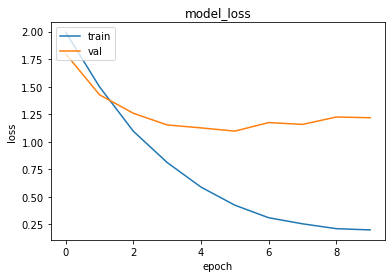

In [151]:
# visualize training and validation losses  
plt.plot(train_sh.history['loss'])
plt.plot(train_sh.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show 

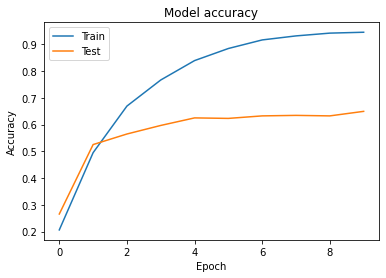

In [152]:
# visualize training and validation accuracies
plt.plot(train_sh.history['accuracy'])
plt.plot(train_sh.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [153]:
loss, accuracy = cnnmodel.evaluate(XD_test, YD_test, verbose=False)
print("Testing Accuracy:  > %.3f"  % (accuracy * 100.0))

Testing Accuracy:  > 63.404


In [168]:
cnnmodel.weights

[<tf.Variable 'embedding_28/embeddings:0' shape=(2000, 128) dtype=float32, numpy=
 array([[-0.01194105, -0.00893595, -0.09128901, ..., -0.01825847,
          0.00260322, -0.0536463 ],
        [ 0.14629889,  0.0564375 , -0.11996924, ...,  0.0667411 ,
          0.11231963, -0.11683479],
        [ 0.04504862,  0.1216522 ,  0.08654026, ...,  0.07509339,
          0.0276182 , -0.08756479],
        ...,
        [ 0.07698343, -0.00126461, -0.03485166, ..., -0.09692236,
         -0.01976166, -0.05523314],
        [-0.03065643,  0.04007576,  0.00551316, ..., -0.02421315,
         -0.09088104,  0.05043201],
        [ 0.04888308, -0.00193551, -0.00225104, ...,  0.00101527,
          0.01284167,  0.03524701]], dtype=float32)>,
 <tf.Variable 'conv1d_48/kernel:0' shape=(5, 128, 124) dtype=float32, numpy=
 array([[[ 0.11764958,  0.05362569, -0.04365219, ..., -0.07531936,
          -0.05758185, -0.01075119],
         [ 0.06658083, -0.06791958,  0.08262946, ..., -0.14793019,
          -0.04753087, -0.0

In [161]:
pred = cnnmodel.predict(XD_test)
pred

array([[7.1353286e-05, 4.6970118e-03, 5.5221899e-05, ..., 9.9411470e-01,
        4.2722994e-04, 5.2578532e-04],
       [3.2200519e-02, 4.4365838e-04, 2.0165445e-02, ..., 1.4575813e-05,
        2.0318982e-04, 7.7187597e-06],
       [8.0848247e-01, 3.6499885e-04, 1.1332112e-02, ..., 1.0961484e-05,
        4.3870890e-04, 7.3916213e-05],
       ...,
       [1.6830009e-04, 1.9250499e-02, 1.9724220e-03, ..., 9.7321337e-01,
        3.3434131e-03, 4.6793290e-04],
       [3.4549189e-01, 8.1585692e-03, 4.5696355e-02, ..., 1.9174709e-03,
        2.4447223e-02, 1.3949456e-02],
       [2.8585739e-06, 2.5214213e-03, 5.7063520e-05, ..., 9.9682790e-01,
        3.8284666e-04, 1.7191574e-04]], dtype=float32)

In [165]:
XD_test

array([[   0,    0,    0, ...,  206,   11,   59],
       [   0,    0,    0, ...,  695,  609,  103],
       [   0,    0,    0, ...,  519,  213,   96],
       ...,
       [   0,    0,    0, ...,  357,   20, 1079],
       [   0,    0,    0, ...,  892,  952,  946],
       [   0,    0,    0, ...,  114, 1634,   74]], dtype=int32)

In [164]:

for n in range(len(pred)):
    print(np.argmax(pred[n], axis=0)+1)

7
5
1
7
7
7
4
7
5
4
5
4
4
7
7
5
7
7
1
1
2
1
7
7
5
2
7
5
7
4
1
4
6
1
5
4
1
4
7
1
1
1
5
6
4
5
6
7
7
7
4
7
6
2
1
7
6
7
2
6
7
3
7
7
4
7
7
4
5
4
7
5
4
1
1
7
7
7
5
1
7
6
7
5
1
1
3
1
4
7
3
6
7
6
5
4
7
7
4
7
4
7
4
4
1
7
6
7
4
1
5
7
7
4
3
7
7
1
7
2
5
2
1
1
4
6
4
2
7
7
6
7
4
7
3
2
7
4
1
7
7
6
4
1
7
1
7
1
7
7
4
4
6
7
1
1
2
1
1
7
7
1
2
6
4
6
5
7
7
1
5
1
7
4
2
1
4
7
1
5
5
4
1
6
7
2
7
4
7
1
1
2
1
4
7
1
6
1
7
7
2
1
1
7
7
2
7
1
7
7
1
2
7
1
7
4
1
7
9
4
7
1
1
2
7
7
7
7
7
4
1
1
4
7
7
1
2
5
1
6
4
7
5
7
1
4
7
1
4
7
7
5
7
1
1
1
4
7
2
1
7
5
6
2
7
1
7
5
7
1
7
4
4
7
7
7
1
7
7
1
7
4
1
5
1
7
4
5
4
7
7
1
1
7
4
1
1
4
4
4
7
5
1
7
6
4
6
1
1
2
3
7
2
7
1
1
7
7
4
4
3
4
4
7
1
1
4
7
4
1
4
5
7
7
2
4
7
5
7
4
7
7
7
4
2
7
1
1
4
7
7
4
4
2
1
1
7
6
7
2
7
7
1
1
5
7
2
6
7
1
7
4
7
6
7
4
7
2
7
6
7
2
2
4
3
7
9
5
4
4
1
2
7
7
2
7
2
7
7
4
1
7
1
2
1
2
6
7
2
4
4
1
1
1
7
7
1
7
1
4
4
2
4
6
4
4
3
7
7
1
4
7
6
4
1
7
1
7
7
7
7
1
4
5
5
7
7
7
6
4
1
1
4
1
1
7
1
1
1
7
4
4
7
6
4
7
1
1
7
2
7
5
7
5
1
2
7
6
1
7
4
4
1
6
7
7
7
1
7
5
4
7
2
7
4
4
7
7
4
4


In [ ]:
clean_text = pre_processing(text_y)

In [ ]:

# Use the Keras tokenizer, vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
# the maximum number of words to keep, based on word frequency.
num_words = 2000 
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(clean_text) # Updates internal vocabulary based on a list of texts.
# Pad the data 
X = tokenizer.texts_to_sequences(clean_text) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=2000) # transforms a lists of integers into a 2D Numpy array of shape

In [55]:
Y_D = pd.get_dummies(dtf['Class']).values
XD_train, XD_test, YD_train, YD_test = train_test_split(X, Y_D, test_size = 0.2, random_state = 42, stratify=Y_D)
print(XD_train.shape, YD_train.shape)
print(XD_test.shape, YD_test.shape)

(2652, 2000) (2652, 9)
(664, 2000) (664, 9)


In [100]:
YD_train.shape

(2652, 9, 1)

In [105]:
XD_train.shape = (2652,2000,1)
YD_train.shape = (2652,9)

In [99]:
XD_train

array([[[   0],
        [   0],
        [   0],
        ...,
        [ 272],
        [ 128],
        [ 474]],

       [[   0],
        [   0],
        [   0],
        ...,
        [ 732],
        [ 223],
        [   4]],

       [[   0],
        [   0],
        [   0],
        ...,
        [ 218],
        [ 150],
        [ 388]],

       ...,

       [[   0],
        [   0],
        [   0],
        ...,
        [1620],
        [  63],
        [1212]],

       [[   0],
        [   0],
        [   0],
        ...,
        [  76],
        [  28],
        [  73]],

       [[   0],
        [   0],
        [   0],
        ...,
        [1836],
        [   6],
        [  56]]], dtype=int32)

In [111]:
input_model = layers.Input(shape = (2000,1))
conv1 = layers.Conv1D(64, kernel_size = [3], activation = "relu")(input_model)
pool1 = layers.MaxPooling1D(pool_size = [2])(conv1)
conv2 = layers.Conv1D(32, kernel_size = [3], activation = "relu")(pool1)
pool2 = layers.MaxPooling1D(pool_size = [2])(conv2)
flat =  layers.Flatten()(pool2)
drop =  layers.Dropout(0.5)(flat)
output = layers.Dense(units = 10,  activation = "softmax")(drop)

In [112]:
model_fonc = keras.Model(inputs = input_model, outputs = output)

In [115]:
model_fonc.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = "adam",
    metrics = ["accuracy"]
)

In [117]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_sh = model_fonc.fit(
    XD_train, YD_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [288]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-116-0784e71a0fe7>:4) ]] [Op:__inference_train_function_11625]

Function call stack:
train_function


In [84]:
YD_train

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)